### Imports

This notebook employs standard data science and ML libraries (`numpy`, `pandas`, `scikit-learn`) and visualization libraries (`matplotlib` and `seaborn`).

In [35]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

import os

# plot formatting
plt.style.use('bmh')
plt.rcParams['font.size'] = 12

### Load Data

We'll load the raw csv file into a pandas dataframe for exploration. Based on the metadata, we know that the column 'Property Id' is unique for each row and so we set that as the index column. We'll start exploring some basic features about dataset by inspecting the first few rows, inspecting the shape of the dataset, and sifting through columns that are already set with a numerical data type. 

In [36]:
# Read in raw data file
data = pd.read_csv("../data/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv", index_col="Property Id")

In [37]:
# Print first few lines
data.head()

,Order,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
Property Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13286,1,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
28400,2,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
4778226,3,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
4778267,4,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10

Next we'll print some basic information about the dataset: its shape, features, and summary statistics.

In [38]:
# Shape information 
print(f"Shape of dataset: {data.shape}")

# Numeric features
numeric_cols = data.select_dtypes(include=['number']).columns
print("\nNumeric Columns:",  numeric_cols)

# Numeric features
nonnumeric_cols = data.select_dtypes(exclude=['number']).columns
print("\nNon-numeric Columns:",  nonnumeric_cols)

Shape of dataset: (11746, 59)

Numeric Columns: Index(['Order', 'DOF Gross Floor Area', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy',
       'Property GFA - Self-Reported (ft²)', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract'],
      dtype='object')

Non-numeric Columns: Index(['Property Name', 'Parent Property Id', 'Parent Property Name',
       'BBL - 10 digits', 'NYC Borough, Block and Lot (BBL) self-reported',
       'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)',
       'Address 2', 'Postal Code', 'Street Number', 'Street Name', 'Borough',
       'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type',
       '3rd Largest 

Looking at the cell above, we see that there are many columns which hold numerical data, such as those in units of ft² and kBtu. Based on the `data.head()` information, we also know that missing data are indicated with cells that store the string `"Not Available."`. Let's start the data cleaning process by first changing all missing values to `nan`. Next we'll identify columns that store numerical data by checking if they contain a unit (energy, volume, mass, etc.) and convert them to `float` types. Then we can view summary stats for all numeric columns with `data.describe()`.

In [39]:
# replace all instances of 'Not Available' with nan
data = data.replace({'Not Available': np.nan})

# We'll also manually add the ENERGY STAR Score column

units = ['ft', 'kBtu', 'Number of', 'Percent', 'Hours', 'gal', 'Tons', 'kWh', 'ENERGY STAR Score', 'kgal']

for col in data.columns:
    # check if there are any units or any other indication that this column is numeric
    for token in units:
        if token in col:
            try:
                data[col] = data[col].astype(float)
            except:
                print(f"Couldn't convert column '{col}'.")

# summary stats on numeric columns
data.describe()


,Order,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.000000,1.162800e+04,1.174400e+04,3741.000000,1484.000000,11746.000000,11746.000000,11746.000000,9642.000000,11583.000000,10281.000000,10959.000000,9783.000000,10281.000000,9.000000e+00,2.581000e+03,1.321000e+03,5.940000e+02,1.600000e+01,9.360000e+02,1.030400e+04,1.150200e+04,1.096000e+04,1.167200e+04,1.166300e+04,1.168100e+04,1.174600e+04,7.762000e+03,7762.000000,11583.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000
mean,7185.759578,1.732695e+05,1.605524e+05,22778.682010,12016.825270,1948.738379,1.289971,98.762557,59.854594,280.071484,309.747466,11.072643,1.901441,417.915709,3.395398e+06,3.186882e+06,5.294367e+06,2.429105e+06,1.193594e+06,2.868907e+08,5.048545e+07,5.965472e+06,1.768752e+06,4.553657e+03,2.477937e+03,2.076339e+03,1.673739e+05,1.591798e+04,136.172432,385.908029,40.754379,-73.957057,7.140673,15.771275,4977.596647
std,4323.859984,3.367055e+05,3.095746e+05,55094.441422,27959.755486,30.576386,4.017484,7.501603,29.993586,8607.178877,9784.731207,127.733868,97.204587,10530.524339,2.213237e+06,5.497154e+06,5.881863e+06,4.442946e+06,3.558178e+06,3.124603e+09,3.914719e+09,3.154430e+07,9.389154e+06,2.041639e+05,1.954498e+05,5.931295e+04,3.189238e+05,1.529524e+05,1730.726938,9312.736225,0.080120,0.046337,3.954129,15.674375,13520.422990
min,1.000000,5.002800e+04,5.400000e+01,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.085973e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.690797e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.313430e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,40.516065,-74.243582,1.000000,1.000000,1.000000
25%,3428.250000,6.524000e+04,6.520100e+04,4000.000000,1720.750000,1927.000000,1.000000,100.000000,37.000000,61.800000,65.100000,3.800000,0.100000,103.500000,1.663594e+06,2.550378e+05,2.128213e+06,0.000000e+00,5.698020e+04,4.320254e+06,1.098251e+06,1.043673e+06,3.019975e+05,3.287000e+02,1.474500e+02,9.480000e+01,6.699400e+04,2.595400e+03,27.150000,99.400000,40.707226,-73.984662,4.000000,4.000000,100.000000
50%,6986.500000,9.313850e+04,9.132400e+04,8654.000000,5000.000000,1941.000000,1.000000,100.000000,65.000000,78.500000,82.500000,5.300000,0.500000,129.400000,4.328815e+06,1.380138e+06,4.312984e+06,0.000000e+00,2.070020e+05,9.931240e+06,4.103962e+06,1.855196e+06,5.416312e+05,5.002500e+02,2.726000e+02,1.718000e+02,9.408000e+04,4.692500e+03,45.095000,124.900000,40.759130,-73.962810,7.000000,9.000000,201.000000
75%,11054.500000,1.596140e+05,1.532550e+05,20000.000000,12000.000000,1966.000000,1.000000,100.000000,85.000000,97.600000,102.500000,9.200000,0.700000,167.200000,4.938947e+06,4.445808e+06,6.514520e+06,4.293825e+06,2.918332e+05,2.064497e+07,6.855070e+06,4.370302e+06,1.284677e+06,9.084250e+02,4.475000e+02,4.249000e+02,1.584140e+05,8.031875e+03,70.805000,162.750000,40.817623,-73.932443,9.000000,33.000000,531.500000
max,14993.000000,1.354011e+07,1.421712e

The definition for columns regarding 'metered areas' is a bit unclear, so we can inspect those columns by checking what unique values they store. Based on the results, a reasonable assumption is that metered areas refers to areas of the building for which energy and water usage data is measurable.

In [40]:
print("\nUnique values for 'Metered Areas (Water)':\n", data['Metered Areas  (Water)'].unique())

print("\nUnique values for 'Metered Areas (Energy)':\n", data['Metered Areas (Energy)'].unique())


Unique values for 'Metered Areas (Water)':
 [nan 'Whole Building' 'Combination of common and tenant areas'
 'Another configuration' 'Tenant areas only' 'Common areas only'
 'Tenant areas (all energy loads)']

Unique values for 'Metered Areas (Energy)':
 ['Whole Building' nan 'Another configuration' 'Common areas only'
 'Common Area Cooling, Tenant Plug Load/Electricity, Tenant Cooling, Common Area Plug Load/Electricity'
 'Tenant Plug Load/Electricity, Common Area Cooling, Tenant Cooling, Common Area Plug Load/Electricity'
 'Tenant Cooling, Common Area Hot Water, Common Area Heating, Common Area Plug Load/Electricity'
 'Tenant areas only']


We want to predict the "ENERGY STAR Score" column for unseen data points (NYC properties). Looking at the cells above, we see that this column is classified as non-numeric. To investigate, clean, and convert this column, let's print the first few values.

The official definition of the target column is as follows, directly taken from this [link](https://data.cityofnewyork.us/Environment/NYC-Building-Energy-and-Water-Data-Disclosure-for-/5zyy-y8am/about_data). "The 1-100 scale is set so that 1 represents the worst performing buildings and 100 represents the best performing buildings. A score of 50 indicates that a building is performing at the national median, taking into account its size, location, and operating parameters. A score of 75 indicates that a property is performing in the 75th percentile and may be eligible to earn ENERGY STAR Certification. ENERGY STAR Scores are available for many property types. The 1-100 scale is based on the country in which your property is located. "

In [41]:
data['ENERGY STAR Score'].head(15)

Property Id
13286       NaN
28400      55.0
4778226     NaN
4778267     NaN
4778288     NaN
28402      55.0
4778352     NaN
2610789     NaN
2611745     NaN
3616379     NaN
5870374     NaN
5870375     NaN
2637863    93.0
5871253     1.0
2777235    80.0
Name: ENERGY STAR Score, dtype: float64

In [42]:
def missing_values(df):
    # total missing values per column
    total_missing = df.isnull().sum()

    # percentage of missing values
    percent_missing = 100* (total_missing / len(df))

    # missing value table
    table = pd.concat([total_missing, percent_missing], axis=1)

    # rename the columns
    table = table.rename(
        columns = {0: 'Missing Values', 1: '% of Total'}
    )

    # sort by percentage, descending
    table = table.sort_values(by='% of Total', ascending=False)

    # print summmary information
    print(f"Dataframe has {df.shape[1]} columns.")
    print(f"{len(table[table['% of Total']!=0])} columns have missing information.")

    return table

In [43]:
missing_data_table = missing_values(data)

Dataframe has 59 columns.
46 columns have missing information.


Text(0, 0.5, 'Number of Columns')

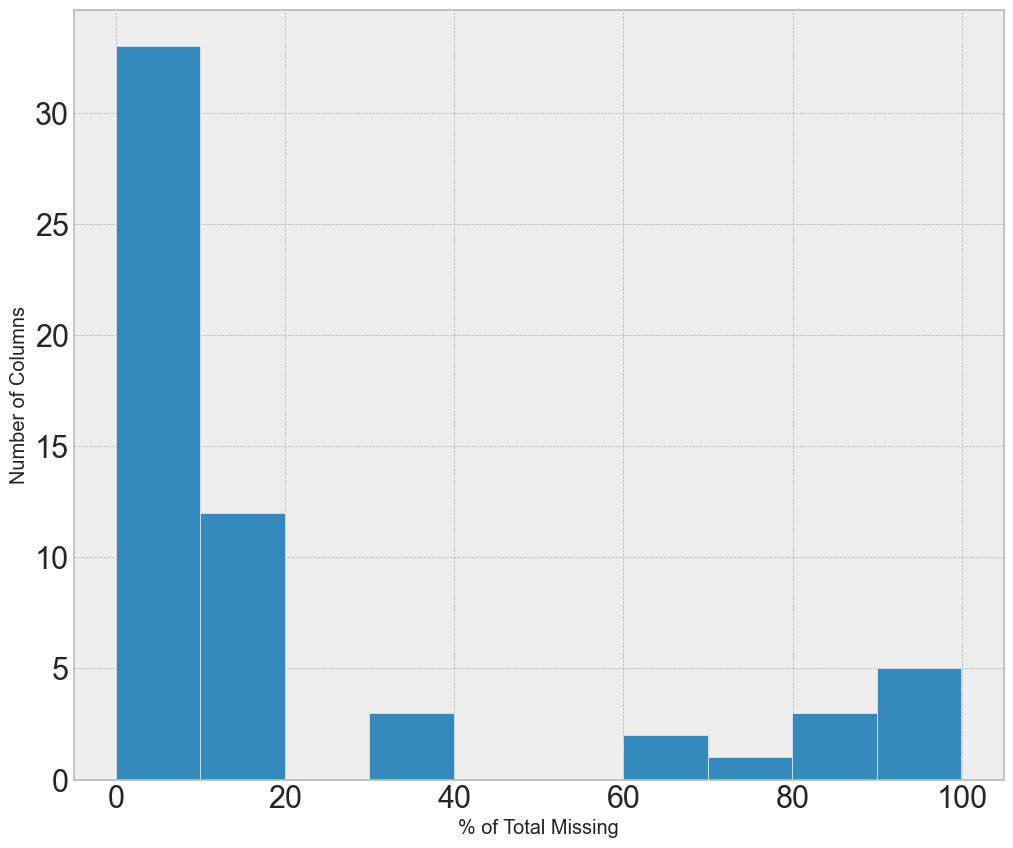

In [44]:
fig = plt.figure()
missing_data_table['% of Total'].hist()
plt.xlabel('% of Total Missing')
plt.ylabel('Number of Columns')

In [45]:
# Filter out columns that have >25% missing data

columns_to_drop = list(missing_data_table[ missing_data_table['% of Total'] > 25 ].index)

data = data.drop(columns=columns_to_drop)
print("Dataframe shape after dropping columns:", data.shape)

Dataframe shape after dropping columns: (11746, 45)


# Exploratory Data Analysis

The next portion of the script will focus on Exploratory Data Analysis (EDA), which refers to the process of making plots and calculations on the data to learn more about its constituent features and data patterns. The purpose of EDA is to find anomalies, trends, or relationships which may be useful when informing modeling decisions downstream. EDA typically begins with a high-level overview and gradually narrows in on more specific features of the dataset. 

We'll start EDA by exploring the Energy Star Score (hereon refered to as just 'score'), which is the target variable for our machine learning model. We'll start with a simple distribution of scores in our dataset.

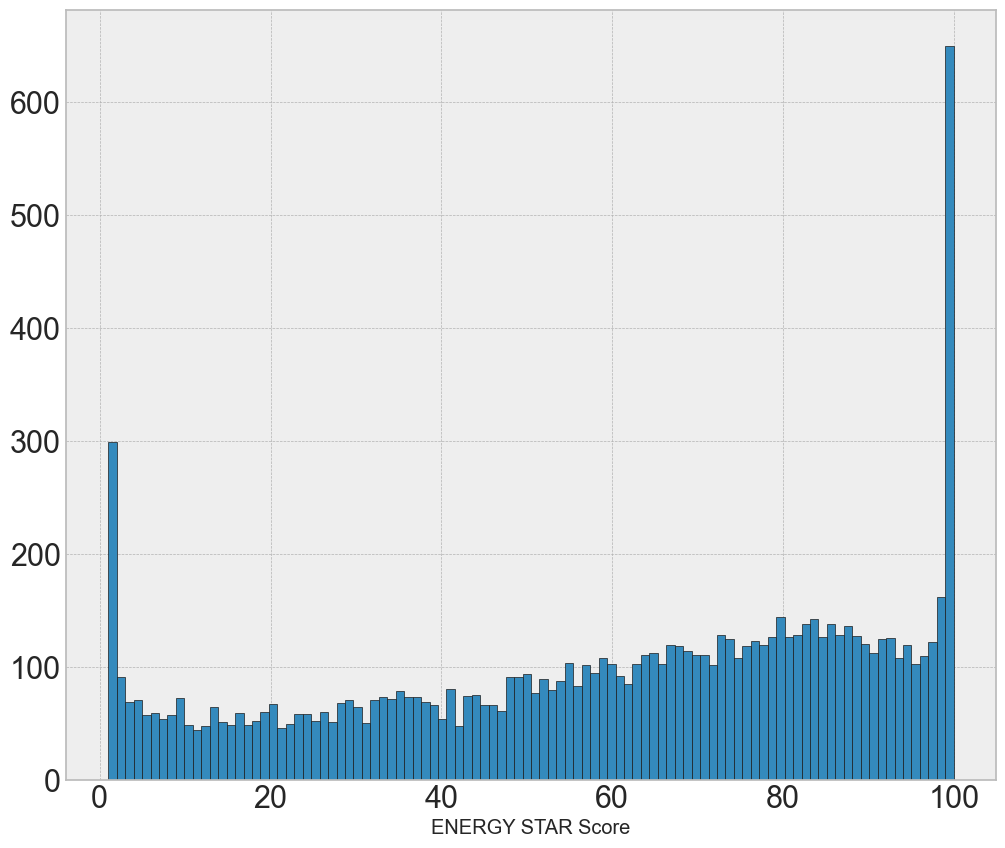

In [46]:
fig = plt.figure()
plt.hist(data['ENERGY STAR Score'].dropna(),bins=100, edgecolor='k')
plt.xlabel("ENERGY STAR Score")
plt.xticks(np.arange(0, 101, 20),np.arange(0, 101, 20));

It's peculiar that there are strong peaks at scores of ~30 and ~60. The distribution is otherwise flat which is to be expected given that energy star scores are equivalent to percentile ranks, according to the official definition (linked [here](https://data.cityofnewyork.us/Environment/NYC-Building-Energy-and-Water-Data-Disclosure-for-/5zyy-y8am/about_data)). The score is based on information provided by applicable property owners to the city. One of these factors is the Site EUI (energy usage intensity), which measures energy usage per square foot. 

In [47]:
print("\nSummary stats:\n", data['Site EUI (kBtu/ft²)'].describe())
print("\nLargest values:\n", data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(10))

data.loc[data['Site EUI (kBtu/ft²)']==869265, :]



Summary stats:
 count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

Largest values:
 Property Id
4390425     51328.8
4390422     51831.2
5870209     78360.1
4022813     84969.6
4043349     95560.2
4022808    103562.7
4022803    112173.6
2946993    126307.4
2610789    143974.4
4414323    869265.0
Name: Site EUI (kBtu/ft²), dtype: float64


,Order,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
Property Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4414323,9984,234 Skillman,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3028937502,3028937502,"3390250 , 3338313",234 Skillman avenue,11211,234,SKILLMAN AVENUE,Brooklyn,61811.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,56900.0,2004,1.0,90,Whole Building,1.0,869265.0,939329.0,9.9,9393.0,986366.0,4.945919e+10,5.344589688E8,1983655.6,563239.6,2627199.1,2627015.0,184.1,56900.0,912801.1,05/01/2017 11:34:14 PM,NaN,In Compliance,40.716233,-73.94141,1.0,34.0,477.0,East Williamsburg ...


Upon the first iteration of plotting Site EUI, I produced a histogram that was uninterpretable due to an extreme outlier. To investigate the outlier, I printed the summary stats above and printed the largest values in the 'Site EUI' column. I found one row with the value `869,265.0` while all others were `< 150,000`. Since there was only one outlier in a database with nearly 12,000 rows, I decided to drop this outlier. This was done using the IQR method in the next cell, followed by the final distribution of Site EUI.

In [48]:
# Remove outlier with IQR
first_quartile = data['Site EUI (kBtu/ft²)'].quantile(0.25)
third_quartile = data['Site EUI (kBtu/ft²)'].quantile(0.75)

# IQR (interquartile range)
iqr = third_quartile - first_quartile

# outliers are either below (0.25 - 3IQR) or above (0.75 + 3IQR)
data = data[
    (data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) & 
    (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))
]

Text(0.5, 1.0, 'Site EUI (kBtu/ft²)')

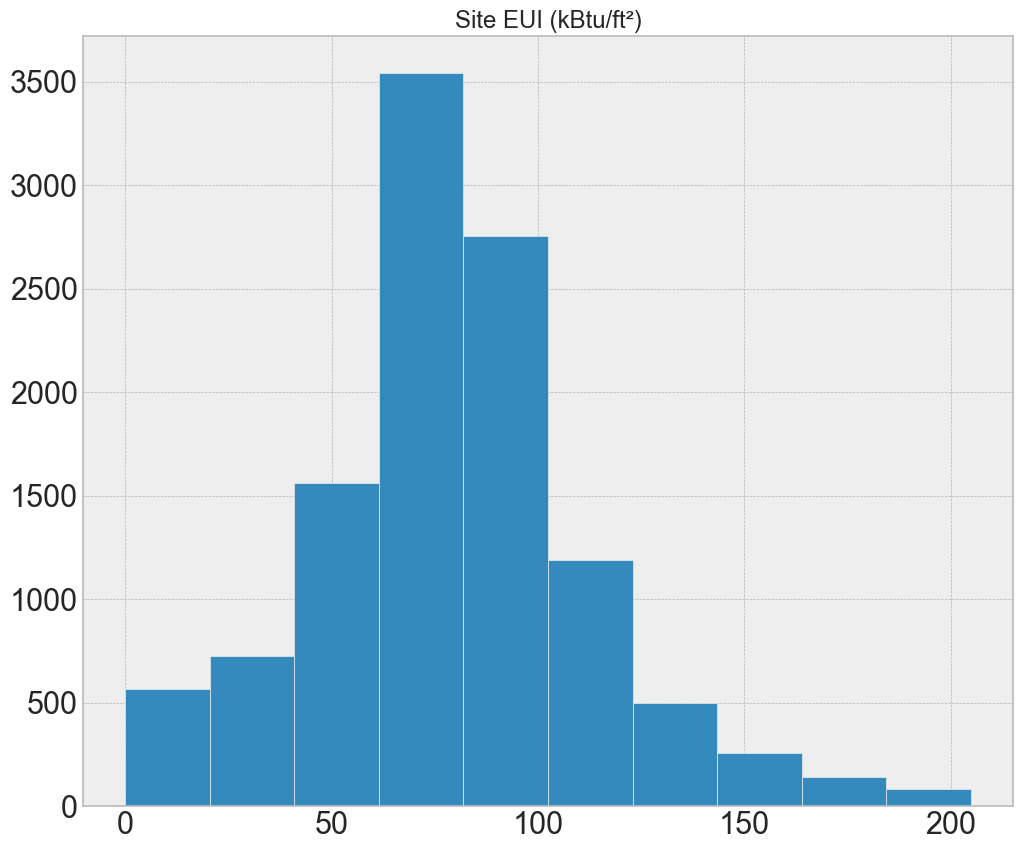

In [49]:
fig = plt.figure()
n_bins = 100
min = data['Site EUI (kBtu/ft²)'].min()
max = data['Site EUI (kBtu/ft²)'].quantile(0.75)
width = (max-min)/n_bins

bins = np.arange(min, max, width)

plt.hist(data['Site EUI (kBtu/ft²)'])
plt.title('Site EUI (kBtu/ft²)')

This distribution appears Gaussian with a positive skew (long tail on the right). The sharp peaks observed in the score distribution do not reappear in this figure.

In [50]:
# explore unique values in the column that indicates property type
column_name = 'Largest Property Use Type'
property_types = list(data[column_name].unique())

print(f"\n\n{column_name}:", data[column_name].unique())
print(f"\nDataset contains {data[column_name].nunique()} unique property types from column `{column_name}`.")



Largest Property Use Type: ['Multifamily Housing' 'College/University' 'Residence Hall/Dormitory'
 'Office' 'Medical Office' 'Library' 'Social/Meeting Hall' 'Other'
 'Self-Storage Facility' 'Strip Mall' 'Retail Store' 'Bank Branch'
 'Movie Theater' 'Hospital (General Medical & Surgical)' 'Enclosed Mall'
 'K-12 School' 'Other - Recreation' 'Financial Office'
 'Manufacturing/Industrial Plant' 'Performing Arts'
 'Other - Lodging/Residential' 'Hotel' 'Non-Refrigerated Warehouse'
 'Parking' 'Other - Entertainment/Public Assembly' 'Restaurant'
 'Senior Care Community' 'Worship Facility' 'Distribution Center'
 'Urgent Care/Clinic/Other Outpatient' 'Other - Mall' 'Other - Education'
 'Museum' 'Automobile Dealership' 'Other - Specialty Hospital'
 'Residential Care Facility' 'Outpatient Rehabilitation/Physical Therapy'
 'Pre-school/Daycare' 'Supermarket/Grocery Store'
 'Mailing Center/Post Office' 'Courthouse' 'Wholesale Club/Supercenter'
 'Other - Services' 'Other - Public Services' 'Refriger

In [51]:
# explore unique values in the column that indicates property type
column_name = 'Primary Property Type - Self Selected'
property_types = list(data[column_name].unique())

print(f"\n\n{column_name}:", data[column_name].unique())
print(f"\nDataset contains {data[column_name].nunique()} unique property types from column `{column_name}`.")



Primary Property Type - Self Selected: ['Multifamily Housing' 'College/University' 'Residence Hall/Dormitory'
 'Office' 'Medical Office' 'Library' 'Social/Meeting Hall' 'Other'
 'Self-Storage Facility' 'Strip Mall' 'Retail Store' 'Bank Branch'
 'Movie Theater' 'Hospital (General Medical & Surgical)' 'Enclosed Mall'
 'K-12 School' 'Other - Recreation' 'Mixed Use Property'
 'Financial Office' 'Manufacturing/Industrial Plant' 'Performing Arts'
 'Other - Lodging/Residential' 'Hotel' 'Data Center'
 'Non-Refrigerated Warehouse' 'Parking' 'Restaurant'
 'Senior Care Community' 'Worship Facility' 'Distribution Center'
 'Urgent Care/Clinic/Other Outpatient'
 'Other - Entertainment/Public Assembly' 'Other - Education'
 'Fitness Center/Health Club/Gym' 'Museum' 'Automobile Dealership'
 'Other - Specialty Hospital' 'Residential Care Facility'
 'Outpatient Rehabilitation/Physical Therapy' 'Other - Mall'
 'Pre-school/Daycare' 'Supermarket/Grocery Store'
 'Mailing Center/Post Office' 'Other - Public

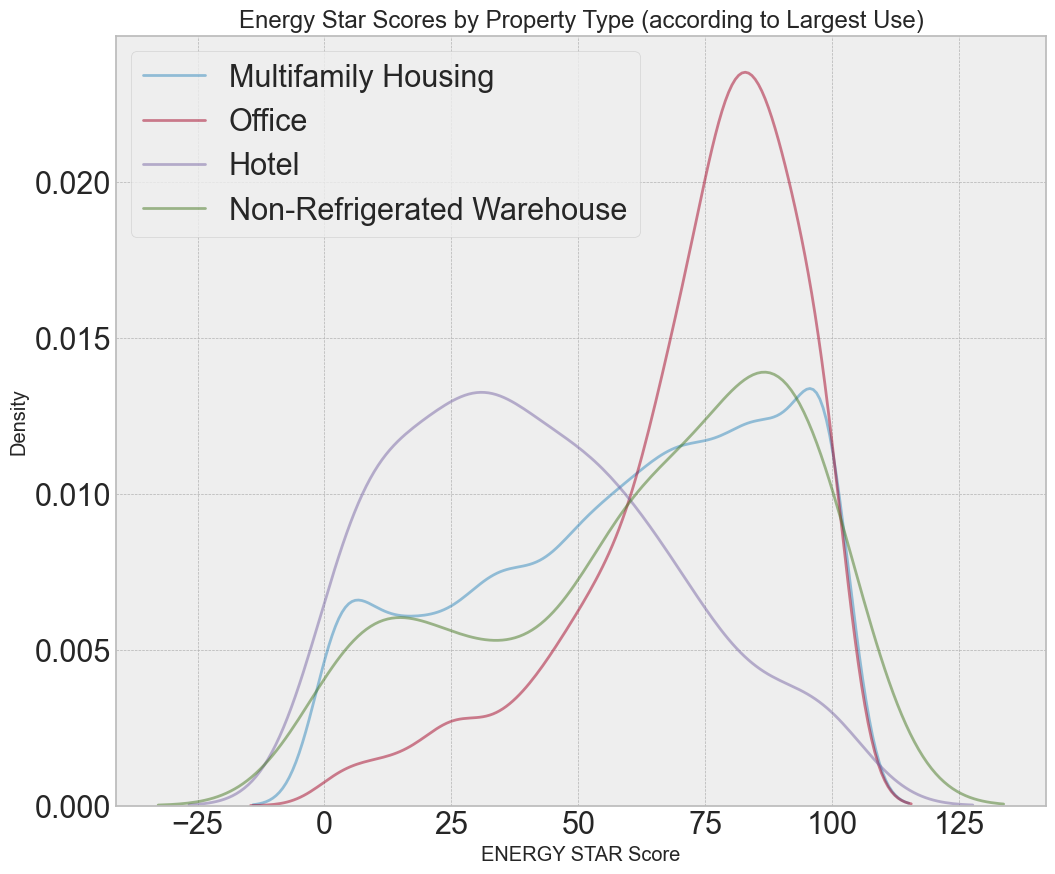

In [52]:
# Plot distribution of Site EUI based on property type in 'largest use' column

# set designated column for determining property type
column_name = 'Largest Property Use Type'

# drop rows with missing score values
data_with_scores = data.dropna(subset=['ENERGY STAR Score'])
property_counts = data_with_scores[column_name].value_counts()
property_types = list(property_counts[property_counts.values > 100].index)

# initiate new figure
fig = plt.figure(figsize=(12,10))

# iterate through property types
for each_type in property_types:
    # filter out relevant rows
    subset = data[data[column_name] == each_type ]
    
    # add to density plot
    sns.kdeplot(
        subset['ENERGY STAR Score'].dropna(),
        label = each_type,
        fill = False,
        alpha = 0.5
        )
plt.legend()
plt.title("Energy Star Scores by Property Type (according to Largest Use)");

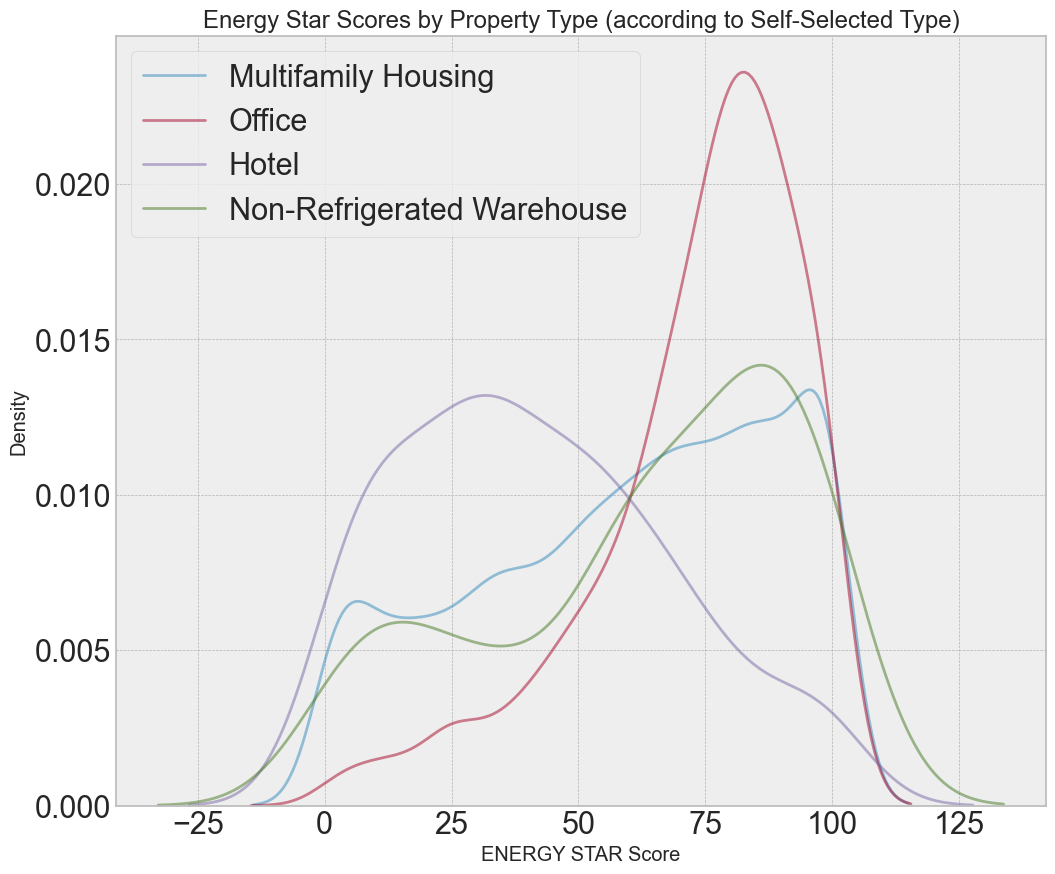

In [53]:
# Plot distribution of Site EUI based on property type in 'largest use' column

# set designated column for determining property type
column_name = 'Primary Property Type - Self Selected'

# drop rows with missing score values
data_with_scores = data.dropna(subset=['ENERGY STAR Score'])
property_counts = data_with_scores[column_name].value_counts()
property_types = list(property_counts[property_counts.values > 100].index)

# initiate new figure
fig = plt.figure(figsize=(12,10))

# iterate through property types
for each_type in property_types[0:5]:
    # filter out relevant rows
    subset = data[data[column_name] == each_type ]
    
    # add to density plot
    sns.kdeplot(
        subset['ENERGY STAR Score'].dropna(),
        label = each_type,
        fill = False,
        alpha = 0.5
        )
plt.legend()
plt.title("Energy Star Scores by Property Type (according to Self-Selected Type)");

The figures above agree well with each other, which is a good sanity check to see that the two categorical columns indicating property type agree well with one another. Since property type does have a role in the star score distribution, we should feed it into the machine learning model (after one-hot encoding). 

In addition to property types, there are other categorical columns such as the borough.


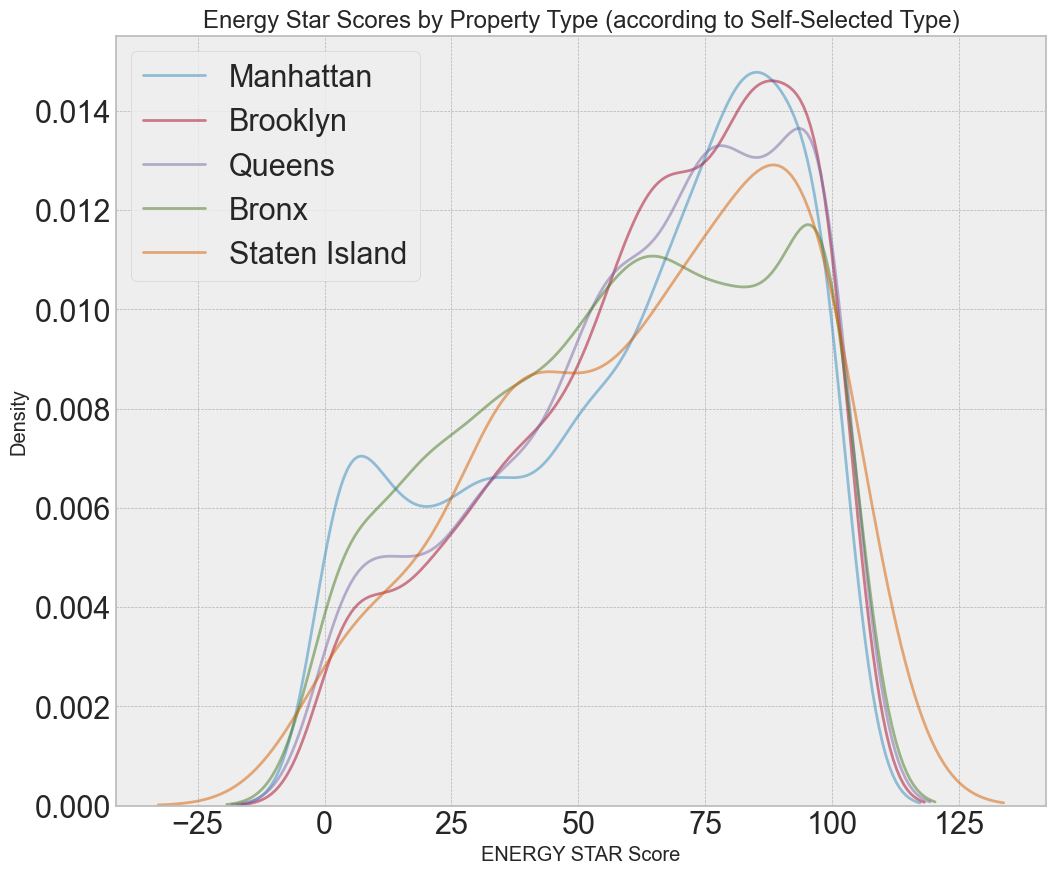

In [54]:
# Plot distribution of Site EUI based on borough

# set designated column for determining property type
column_name = 'Borough'

# drop rows with missing score values
data_with_scores = data.dropna(subset=['ENERGY STAR Score'])
borough_counts = data_with_scores[column_name].value_counts()
borough_types = list(borough_counts[borough_counts.values > 100].index)

# initiate new figure
fig = plt.figure(figsize=(12,10))

# iterate through property types
for each_type in borough_types[0:5]:
    # filter out relevant rows
    subset = data[data[column_name] == each_type ]
    
    # add to density plot
    sns.kdeplot(
        subset['ENERGY STAR Score'].dropna(),
        label = each_type,
        fill = False,
        alpha = 0.5
        )
plt.legend()
plt.title("Energy Star Scores by Property Type (according to Self-Selected Type)");

The borough of the building does not seem to make as significant a difference in the distribution of the score as does the building type. Nonetheless, it might make sense to include the borough as a categorical variable. 

One final density plot we can make is to break out 

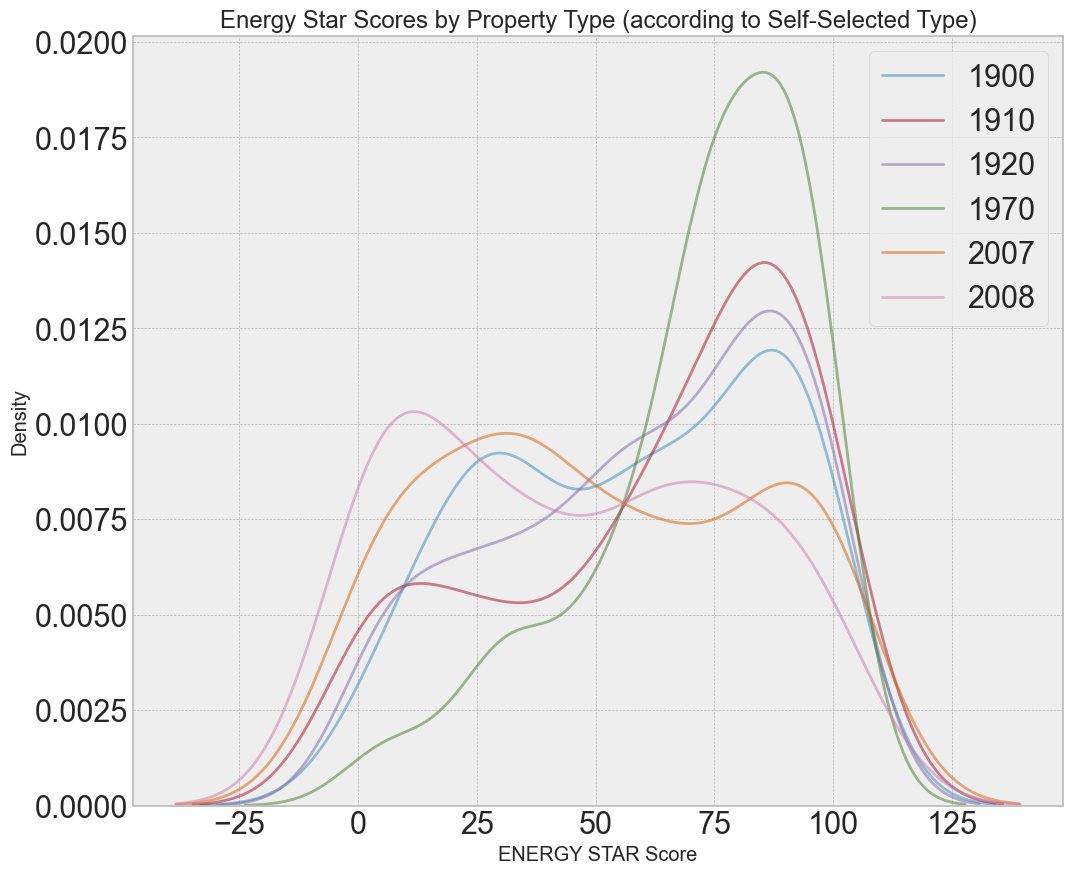

In [55]:
# Plot distribution of Site EUI based on year build

# set designated column for determining property type
column_name = 'Year Built'

# drop rows with missing score values
data_with_scores = data.dropna(subset=['ENERGY STAR Score'])
cat_counts = data_with_scores[column_name].value_counts()
cat_types = list(cat_counts[cat_counts.values > 100].index)
cat_types.sort()

# initiate new figure
fig = plt.figure(figsize=(12,10))

# iterate through property types
for each_type in (cat_types[0:3] +  cat_types[-3:]):
    # filter out relevant rows
    subset = data[data[column_name] == each_type ]
    
    # add to density plot
    sns.kdeplot(
        subset['ENERGY STAR Score'].dropna(),
        label = each_type,
        fill = False,
        alpha = 0.5,
        )
    
plt.legend()
plt.title("Energy Star Scores by Property Type (according to Self-Selected Type)");

Thankfully, it appears that older buildings tend to have a stronger peak at higher energy scores. This could also be related to correlations between the property type and building year. For example, 1970 seems to be a very good year for building efficient properties in terms of energy star scores. Its distribution however looks similar to that of office buildings and Manhattan buildings, so perhaps it isn't necessarily that buildings from 1970 are more energy-efficient, but that a high fraction of offices, which tend to be energy-efficient, were built in 1970. 

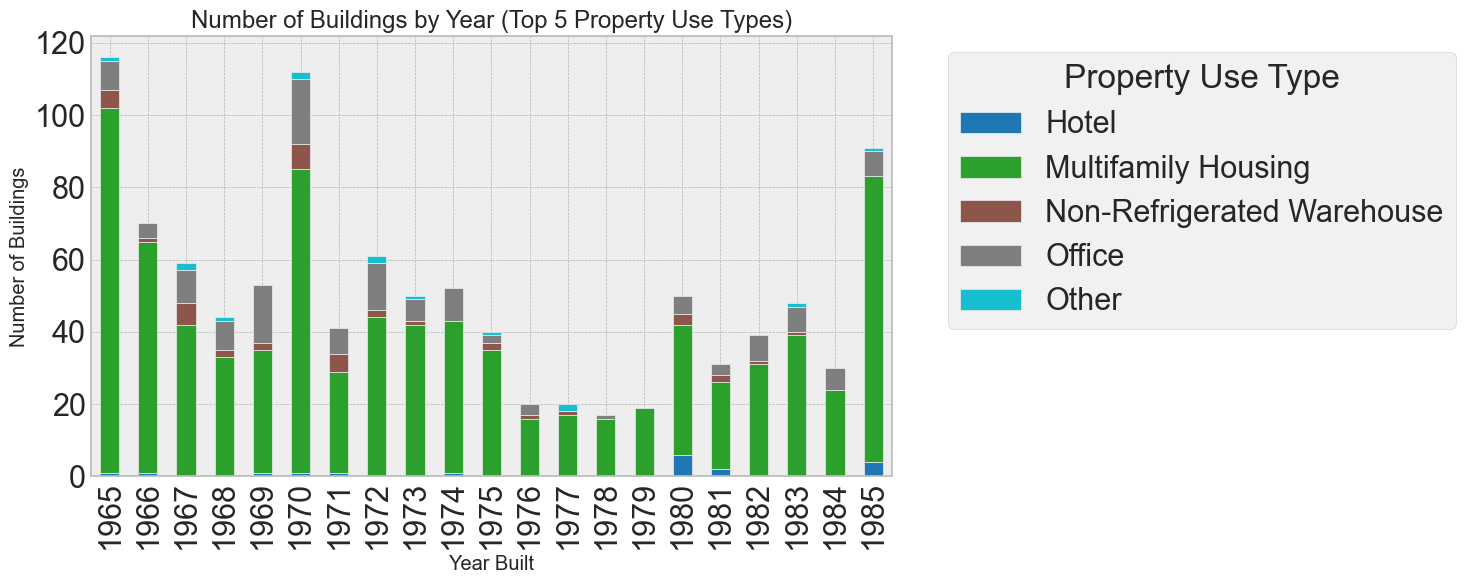

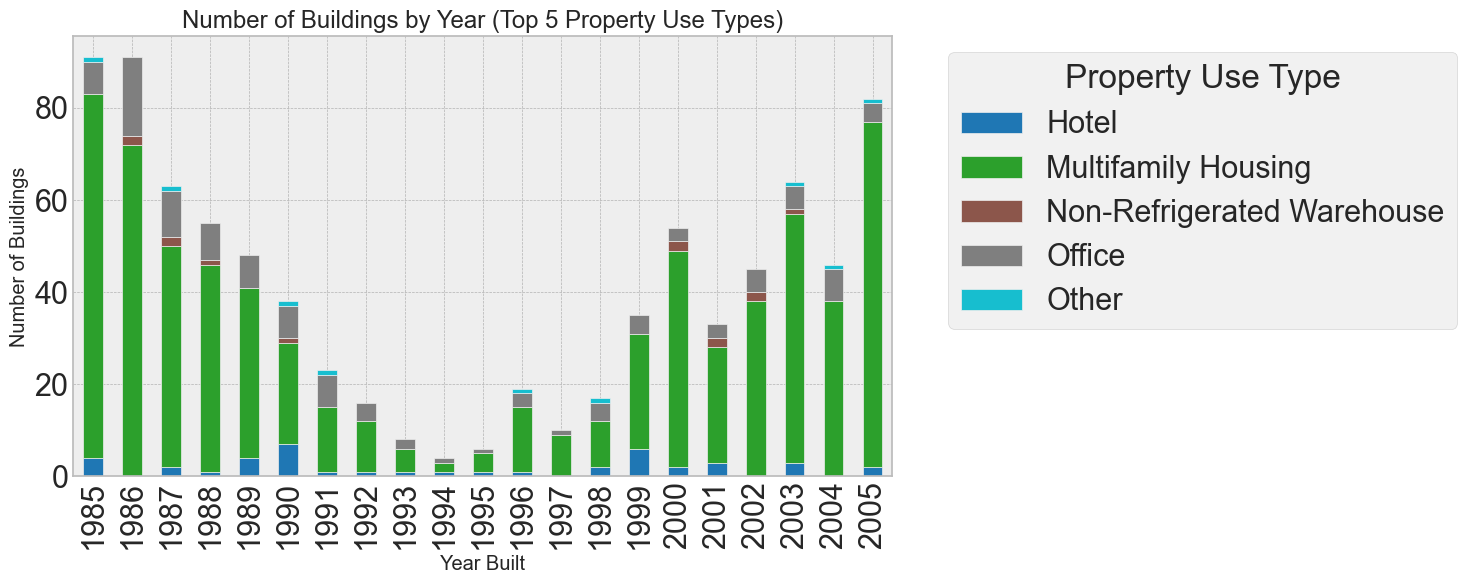

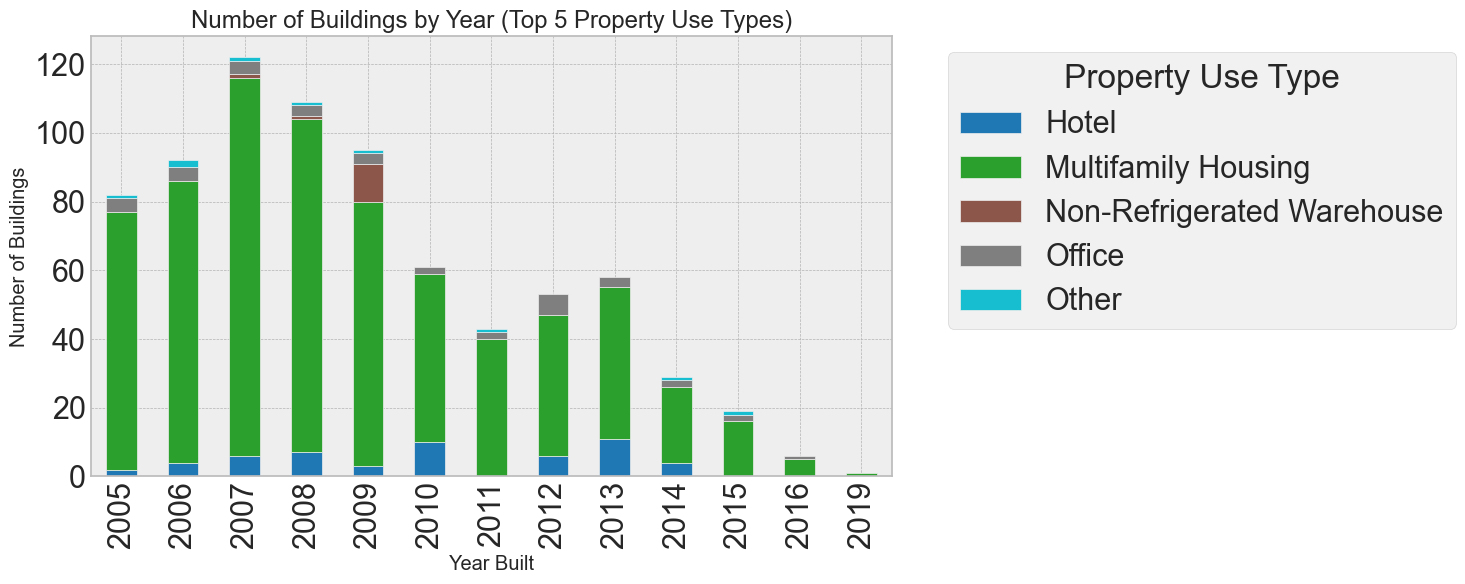

In [56]:
year_ranges = [ 
    [1965, 1985],
    [1985, 2005],
    [2005, 2025]
]

for each_range in year_ranges:
    # Step 1: Get top 5 most common property use types
    top5_types = data['Largest Property Use Type'].value_counts().nlargest(5).index

    # Step 2: Filter to only those 5 types
    filtered_data = data[
        (data['Largest Property Use Type'].isin(top5_types)) &
        (data['Year Built'].between(each_range[0], each_range[1]))
    ]

    # Step 3: Create pivot table: rows=Year Built, columns=Property Type, values=counts
    pivot_table = (
        filtered_data
        .groupby(['Year Built', 'Largest Property Use Type'])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )

    # Step 4: Plot stacked bar chart
    pivot_table.plot(kind='bar', stacked=True, figsize=(15, 6), colormap='tab10')

    plt.title("Number of Buildings by Year (Top 5 Property Use Types)")
    plt.xlabel("Year Built")
    plt.ylabel("Number of Buildings")
    plt.legend(title='Property Use Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


We see that there are more offices built in 1970 relative to most other years (especially more recent years). We also see a sharp peak in the total buildings constructed in that year. We also see trends in construction over time. Here are some summary bullet points about the stacked bar plots above:

- Construction of buildings was relatively constant from 1965 to 1985, with the exception of increased buildings in 1965, 1970, and 1985.
- The majority of new bulidings that are put up every year are multi-family housing.
- A higher fraction of new buildings were office bulidings in 1970.
- There was a steady decline in construction rates from 1986 to 1998.


# Correlation Studies

We can search for correlations between features using the Pearson correlation coefficient. 

['Electricity Use - Grid Purchase (kBtu)', 'Weather Normalized Site Electricity (kWh)', 'Weather Normalized Source EUI (kBtu/ft²)', 'Source EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)']


<Axes: >

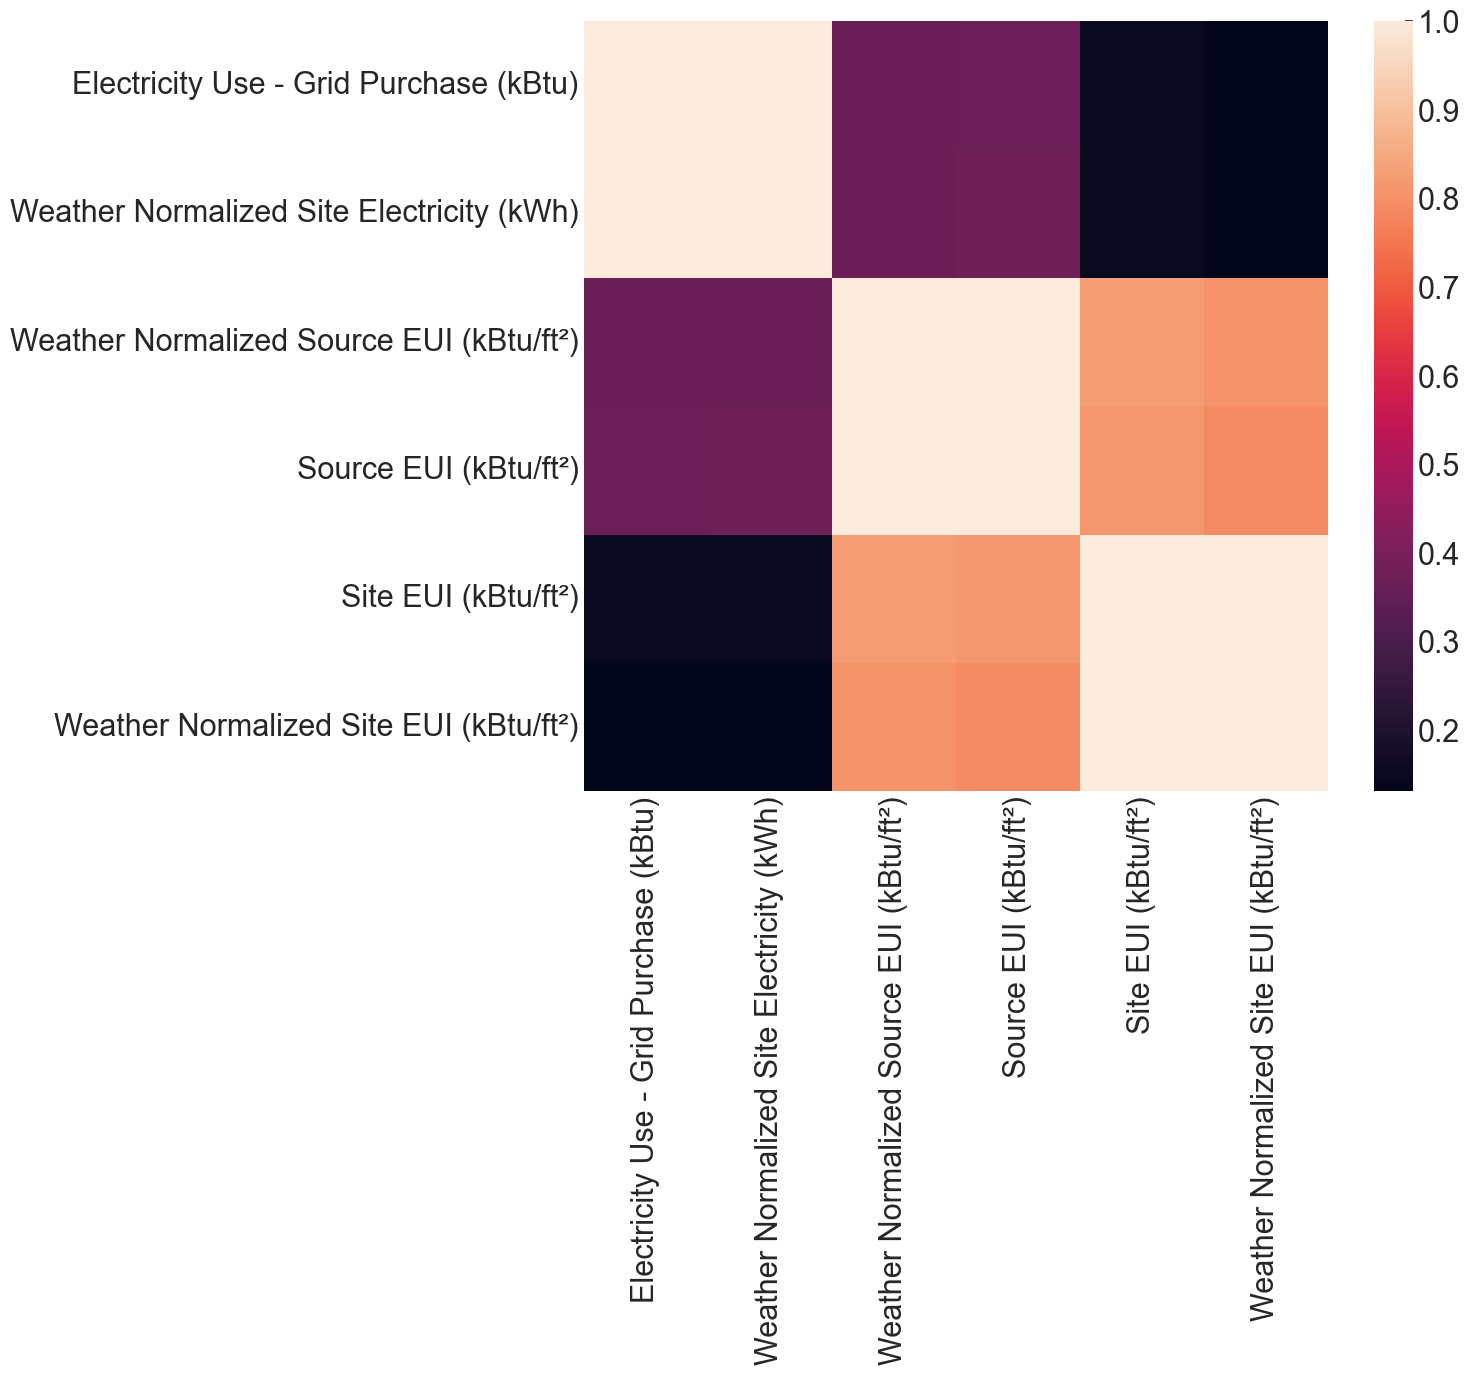

In [57]:
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
correlation_series = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).stack()



top_correlations = correlation_series.nlargest(3)
top_features = correlation_series.abs().sort_values(ascending=False).head(3).index.tolist()

columns_to_keep = []
for each_pair in top_features:
    if each_pair[0] not in columns_to_keep:
        columns_to_keep.append(each_pair[0])
    if each_pair[1] not in columns_to_keep:
        columns_to_keep.append(each_pair[1])

print((columns_to_keep))
high_corr_data = data[columns_to_keep]
sns.heatmap(high_corr_data.corr())


The correlation matrix above allows shows that many columns have a nearly-equivalent partner column. Moreover, there are two versions of many of the figures, one for `Source` and another for `Site`. For example, EUI is split into `Source EUI` and `Site EUI`. Based on this [document](https://www.nyc.gov/html/gbee/downloads/pdf/nyc_ll84_benchmarking_report_2012.pdf), source energy usage figures refer to the total energy needed to create the consumption levels on-site. Site energy usage does not take into account energy generation or losses and is thus a less comprehensive estimate of a property's total energy cost. In addition to site vs source energy usage, the correlation matrix shows us that energy usage columns are also partnered with a weather-normalized column, which exhibit nearly identical correlation coefficients. This is why the 6x6 matrix apears more like a 3x3.

Now let's investigate the correlation between numeric columns and the energy score. 

In [58]:
correlations_data = numeric_data.corr()['ENERGY STAR Score'].sort_values()
print(correlations_data)

Site EUI (kBtu/ft²)                                          -0.723864
Weather Normalized Site EUI (kBtu/ft²)                       -0.713993
Weather Normalized Source EUI (kBtu/ft²)                     -0.645542
Source EUI (kBtu/ft²)                                        -0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346046
Direct GHG Emissions (Metric Tons CO2e)                      -0.147792
Natural Gas Use (kBtu)                                       -0.133648
Year Built                                                   -0.121249
Total GHG Emissions (Metric Tons CO2e)                       -0.113136
Electricity Use - Grid Purchase (kBtu)                       -0.050639
Weather Normalized Site Electricity (kWh)                    -0.048207
Latitude                                                     -0.048196
Indirect GHG Emissions (Metric Tons CO2e)                    -0.043982
Longit

The strongest correlations occur between site EUI and source EUI. These correlations are negative, meaning that a higher EUI value is associated with a lower energy score. This makes sense, as a higher EUI is equivalent to a higher energy consumption per square footage. As we discovered in the previous correlation plot, site vs. source figures have similar correlation coefficients, suggesting that there is a linear relationship between site energy consumption and source energy consumption. We can pick only one of the two measurement standards for analysis.

To account for possible non-linear relationships, we can take square root and natural log transformations of the features and then calculate the correlation coefficients with the score. These transformations would transform exponential or quadratic relationships to a more linear form. To try and capture any possible relationships between the borough or building type (remember these are categorical variables) and the score we will have to one-hot encode these columns.


In [59]:
# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'ENERGY STAR Score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop buildings without an energy star score
features = features.dropna(subset = ['ENERGY STAR Score'])

# Find correlations with the score 
correlations = features.corr()['ENERGY STAR Score'].dropna().sort_values()

/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/a

In [60]:
# Display most negative correlations
correlations.head(15)

Site EUI (kBtu/ft²)                                            -0.723864
Weather Normalized Site EUI (kBtu/ft²)                         -0.713993
sqrt_Site EUI (kBtu/ft²)                                       -0.699817
sqrt_Weather Normalized Site EUI (kBtu/ft²)                    -0.689019
sqrt_Weather Normalized Source EUI (kBtu/ft²)                  -0.671044
sqrt_Source EUI (kBtu/ft²)                                     -0.669396
Weather Normalized Source EUI (kBtu/ft²)                       -0.645542
Source EUI (kBtu/ft²)                                          -0.641037
log_Source EUI (kBtu/ft²)                                      -0.622892
log_Weather Normalized Source EUI (kBtu/ft²)                   -0.620329
log_Site EUI (kBtu/ft²)                                        -0.612039
log_Weather Normalized Site EUI (kBtu/ft²)                     -0.601332
log_Weather Normalized Site Electricity Intensity (kWh/ft²)    -0.424246
sqrt_Weather Normalized Site Electricity Intensity 

In [61]:
# Display most positive correlations
correlations.tail(15)

sqrt_Order                                                         0.028662
Borough_Queens                                                     0.029545
Largest Property Use Type_Supermarket/Grocery Store                0.030038
Largest Property Use Type_Residence Hall/Dormitory                 0.035407
Order                                                              0.036827
Largest Property Use Type_Hospital (General Medical & Surgical)    0.048410
Borough_Brooklyn                                                   0.050486
log_Community Board                                                0.055495
Community Board                                                    0.056612
sqrt_Community Board                                               0.058029
sqrt_Council District                                              0.060623
log_Council District                                               0.061101
Council District                                                   0.061639
Largest Prop

Even after data transformations, Site UI is still the most strong negatively-correlated feature to energy scores. There are no strong positive linear relationships although we do see that a building type of office (`Largest Property Use Type_Office`) is slightly positively correlated with the score. This variable is a one-hot encoded representation of the categorical variables for building type. To visualize the correlation between energy scores and site EUI, we can make a scatter plot. We'll use different colors to distinguish different property types. 

Text(0.5, 1.0, 'Energy Star Score vs Site EUI')

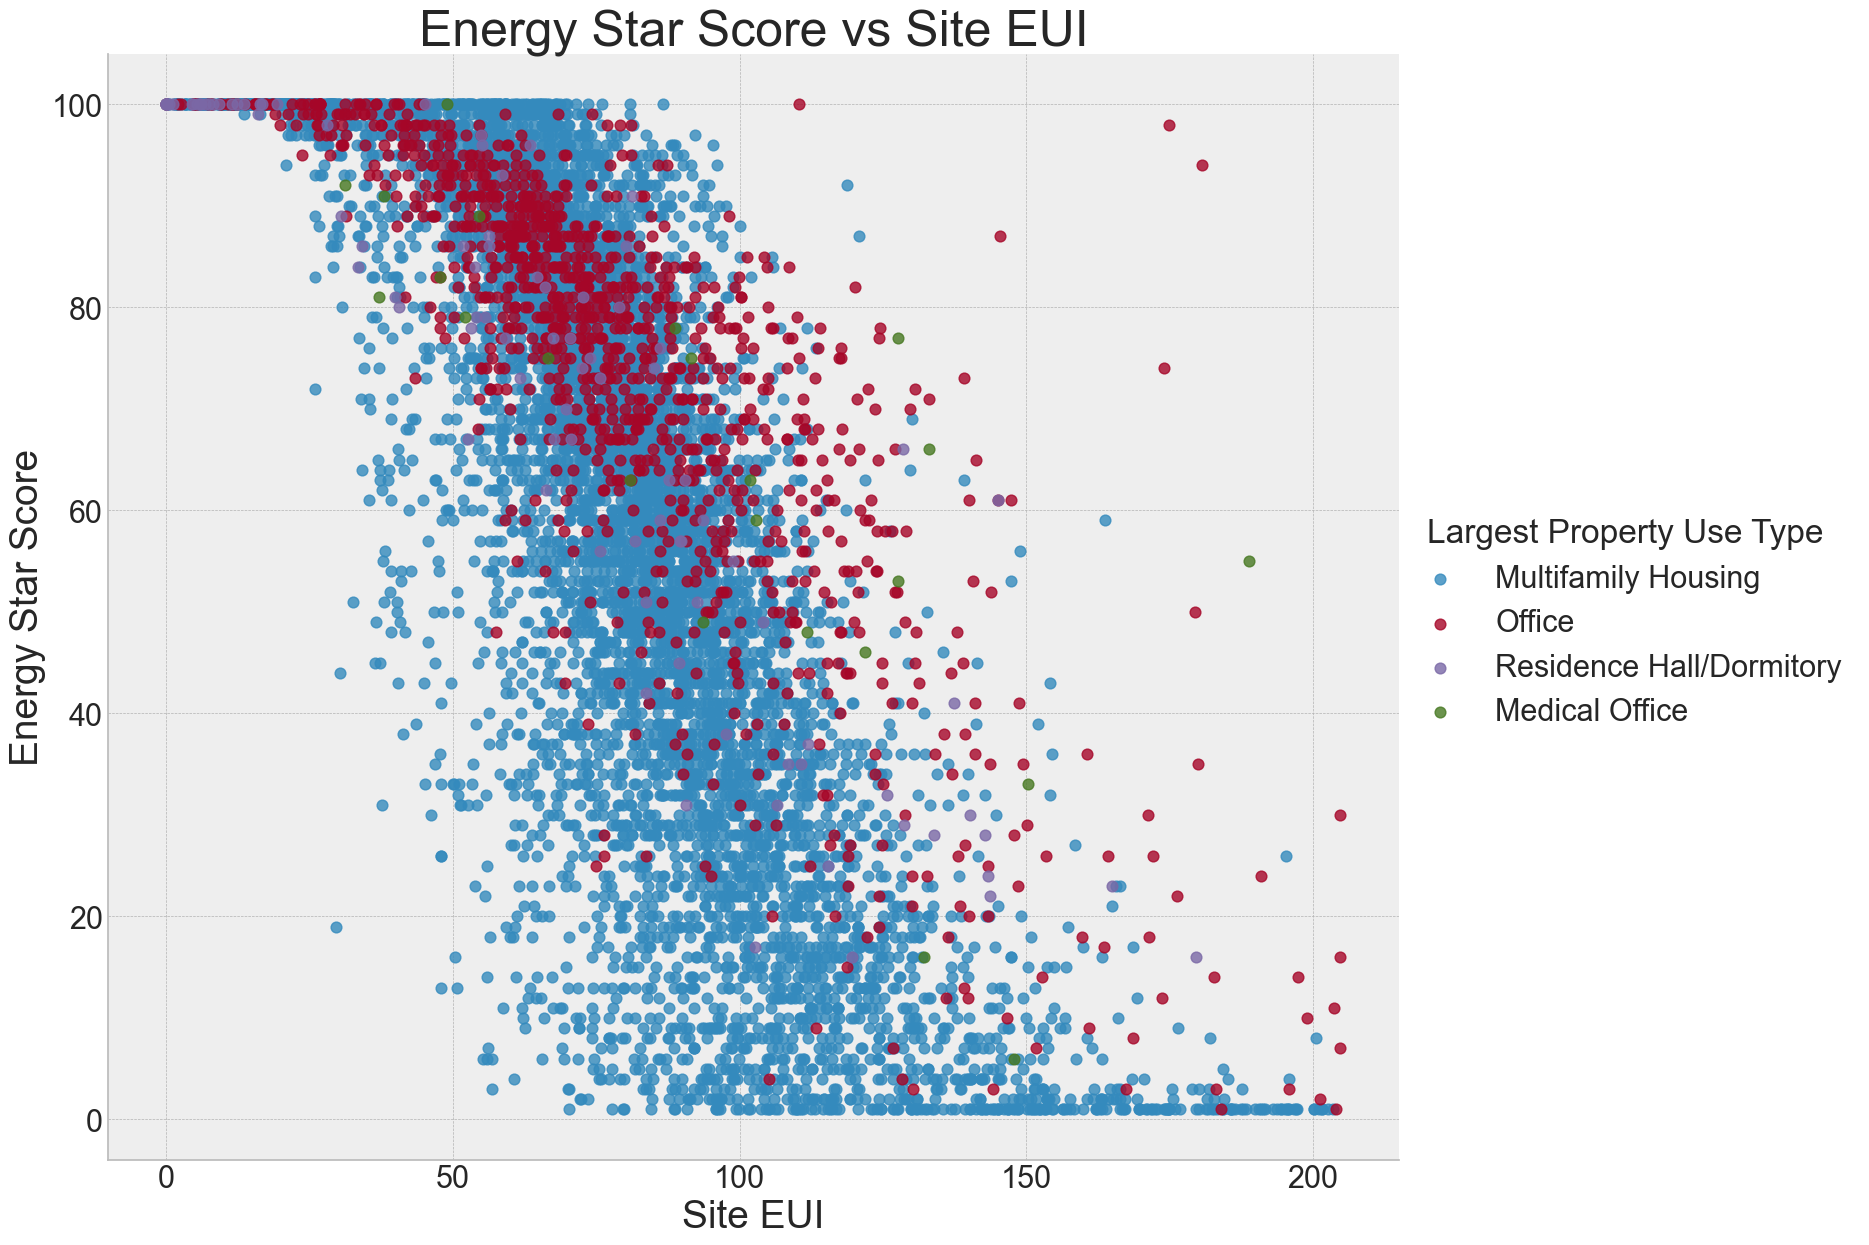

In [62]:
from IPython.core.pylabtools import figsize

column_name = 'Largest Property Use Type'
property_types = list(data[column_name].unique()[0:5])

# Set figure size
figsize(12, 10)

# Extract building types for rows where 'score' is not NaN
features['Largest Property Use Type'] = data.dropna(subset=['ENERGY STAR Score'])['Largest Property Use Type']

# Filter to building types with more than 100 observations
features = features[features['Largest Property Use Type'].isin(property_types)]

# Create the scatterplot using seaborn
sns.lmplot(
    data=features,
    x='Site EUI (kBtu/ft²)',
    y='ENERGY STAR Score',
    hue='Largest Property Use Type',
    scatter_kws={'alpha': 0.8, 's': 60},
    fit_reg=False,
    height=12,
    aspect=1.2
)

# Customize labels and title
plt.xlabel("Site EUI", fontsize=28)
plt.ylabel("Energy Star Score", fontsize=28)
plt.title("Energy Star Score vs Site EUI", fontsize=36)


This plot confirms the relationship we saw in the correlation coefficient: the energy score is inversely related to the site EUI. Though the relationship doesn't look linear, the site EUI will be important for predicting energy scores in unseen data.

As a final exercise for exploratory data analysis, we can make a pairs plot between several different variables. Pairs plots are scatter plots between pairs of variables and histograms of single variables on the diagonal. 

Text(0.5, 1.02, 'Pairs Plot of Energy Data')

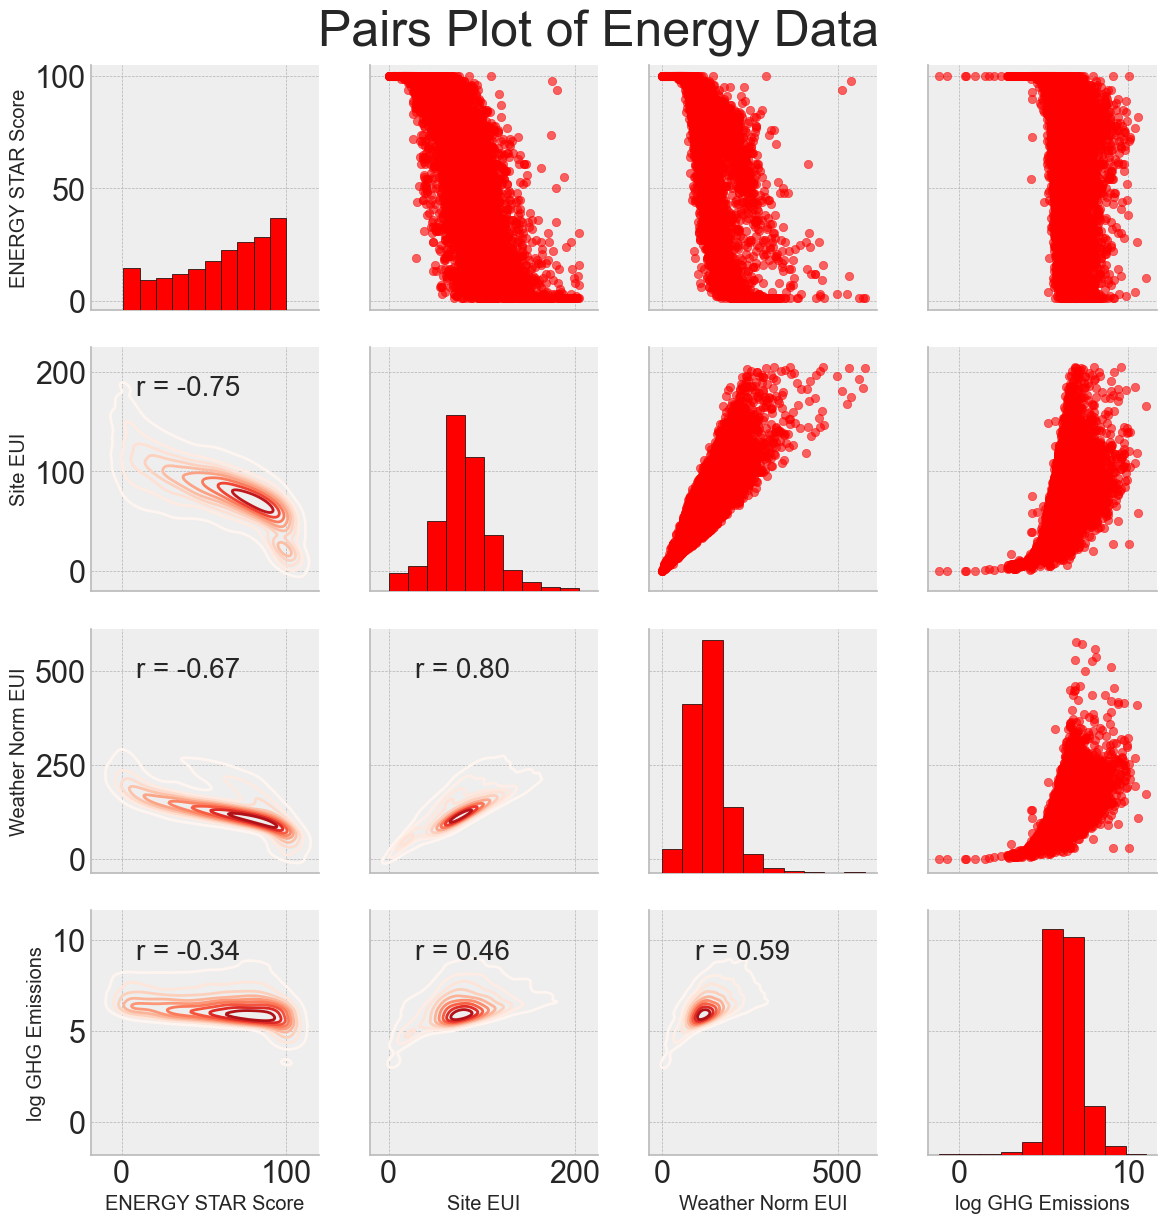

In [63]:
# Extract the columns to plot
plot_data = features[['ENERGY STAR Score', 'Site EUI (kBtu/ft²)', 
                      'Weather Normalized Source EUI (kBtu/ft²)', 
                      'log_Total GHG Emissions (Metric Tons CO2e)']]

# Replace inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Rename columns for cleaner plot labels
plot_data = plot_data.rename(columns={
    'Site EUI (kBtu/ft²)': 'Site EUI',
    'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
    'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'
})

# Drop rows with missing values
plot_data = plot_data.dropna()

# Function to annotate correlation
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate(f"r = {r:.2f}", xy=(.2, .8), xycoords=ax.transAxes, size=20)

# Create the PairGrid
grid = sns.PairGrid(data=plot_data, height=3)

# Map plots to upper, diagonal, and lower
grid.map_upper(plt.scatter, color='red', alpha=0.6)
grid.map_diag(plt.hist, color='red', edgecolor='black')
grid.map_lower(corr_func)
grid.map_lower(sns.kdeplot, cmap='Reds')

# Add overall title
plt.suptitle('Pairs Plot of Energy Data', size=36, y=1.02)


The energy score also exhibits a strong correlation with weather-normalized source EUI. The log GHG emissions is the only figure here with a flat density plot (lower-left corner). 

# Feature Engineering and Selection

Now we can move on to engineering a set of features for use in machine learning models based on the results of the EDA. In particular, we learned the following from EDA which can help us in engineering/selecting features:

* The score distribution varies by building type and to a lesser extent by borough. Although we will focus on numerical features, we should also include these two categorical features in the model. 
* Taking the log transformation of features does not result in significant increases in the linear correlations between features and the score


Before we get any further, we should define what feature engineering and selection are! These definitions are informal and have considerable overlap, but I like to think of them as two separate processes:

* __[Feature Engineering](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)__: The process of taking raw data and extracting or creating new features that allow a machine learning model to learn a mapping beween these features and the target. This might mean taking transformations of variables, such as we did with the log and square root, or one-hot encoding categorical variables so they can be used in a model. Generally, I think of feature engineering as __adding__ additional features derived from the raw data.
* __[Feature Selection](https://machinelearningmastery.com/an-introduction-to-feature-selection/)__: The process of choosing the most relevant features in your data. "Most relevant" can depend on many factors, but it might be something as simple as the highest correlation with the target, or the features with the [most variance](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html). In feature selection, we remove features that do not help our model learn the relationship between features and the target. This can help the model generalize better to new data and results in a more interpretable model. Generally, I think of feature selection as __subtracting__ features so we are left with only those that are most important.

Feature engineering and selection are iterative processes that will usually require several attempts to get right. Often we will use the results of modeling, such as the feature importances from a random forest, to go back and redo feature selection, or we might later discover relationships that necessitate creating new variables. Moreover, these processes usually incorporate a mixture of domain knowledge and statistical qualitites of the data.

[Feature engineering and selection](https://www.featurelabs.com/blog/secret-to-data-science-success/) often has the highest returns on time invested in a machine learning problem. It can take quite a while to get right, but is often more important than the exact algorithm and hyperparameters used for the model. If we don't feed the model the correct data, then we are setting it up to fail and we should not expect it to learn! 

In this project, we will take the following steps for feature engineering:

* Select only the numerical variables and two categorical variables (borough and property use type)
* Add in the log transformation of the numerical variables
* One-hot encode the categorical variables

For feature selection, we will do the following:

* Remove [collinear features](https://statinfer.com/204-1-9-issue-of-multicollinearity-in-python/)

We will discuss collinearity (also called [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)) when we get to that process! 

The following code selects the numeric features, adds in log transformations of all the numeric features, selects and one-hot encodes the categorical features, and joins the sets of features together. 

In [64]:
# Copy the original data
features = data.copy()

units = ['ft', 'kBtu', 'Number of', 'Percent', 'Hours', 'gal', 'Tons', 'kWh', 'ENERGY STAR Score', 'kgal']

for col in features.columns:
    # check if there are any units or any other indication that this column is numeric
    for token in units:
        if token in col:
            try:
                features[col] = features[col].astype(float)
            except:
                print(f"Couldn't convert column '{col}'.")


# Select the numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns
print(numeric_cols)
numeric_subset = data[numeric_cols]
#numeric_subset = data.select_dtypes('number')

# Create columns with log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

print(features.shape)

Index(['Order', 'DOF Gross Floor Area',
       'Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy', 'ENERGY STAR Score',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Weather Normalized Source EUI (kBtu/ft²)', 'Natural Gas Use (kBtu)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Weather Normalized Site Electricity (kWh)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)',
       'Property GFA - Self-Reported (ft²)', 'Source EUI (kBtu/ft²)',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract'],
      dtype='object')
(11319, 103)


/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/a

At this point, we have 11319 observations (buildings) with 103 different features (one column is the score). Not all of these features are likely to be important for predicting the score, and several of these features are also redundant because they are highly correlated. We will deal with this second issue below. 

## Remove Collinear Features

Highly [collinear features](http://psychologicalstatistics.blogspot.com/2013/11/multicollinearity-and-collinearity-in.html) have a significant correlation coefficent between them. For example, in our dataset, the `Site EUI` and `Weather Norm EUI` are highly correlated because they are just slightly different means of calculating the energy use intensity. We touched upon this earlier when making correlation coefficients, but we can observe the collinearity more directly with a scatter plot.

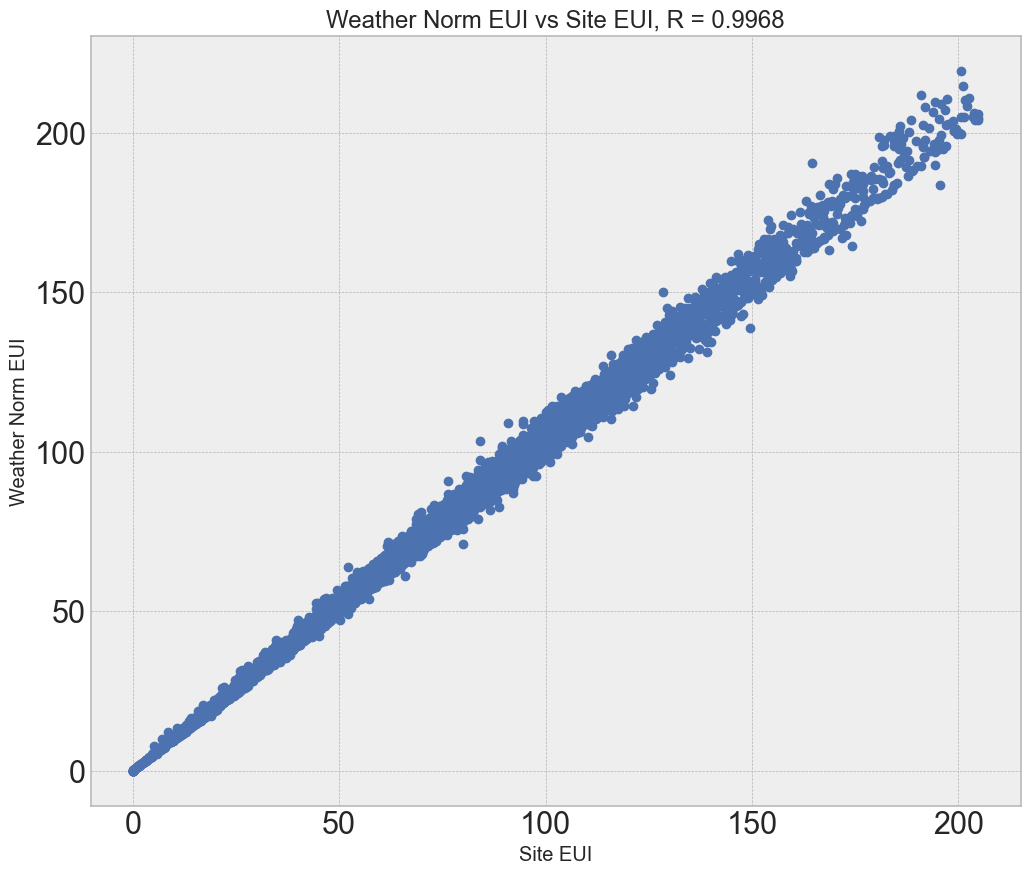

In [65]:
plot_data = data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna()

plt.plot(plot_data['Site EUI (kBtu/ft²)'], plot_data['Weather Normalized Site EUI (kBtu/ft²)'], 'bo')
plt.xlabel('Site EUI'); plt.ylabel('Weather Norm EUI')
plt.title('Weather Norm EUI vs Site EUI, R = %0.4f' % np.corrcoef(data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna(), rowvar=False)[0][1]);

While variables in a dataset are usually correlated to a small degree, highly collinear variables can be redundant in the sense that we only need to retain one of the features to give our model the necessary information.

Removing collinear features is a method to reduce model complexity by decreasing the number of features and can help to increase model generalization.  It can also help us to interpret the model because we only have to worry about a single variable, such as EUI, rather than how both EUI and weather normalized EUI affect the score. 

There are a number of methods for removing collinear features, such as using the [Variance Inflation Factor](http://www.statisticshowto.com/variance-inflation-factor/). We will use a simpler metric, and remove features that have a correlation coefficient above a certain threshold with each other (not with the score because we want variables that are highly correlated with the score!) For a more thorough discussion of removing collinear variables, check out [this notebook on Kaggle](https://www.kaggle.com/robertoruiz/dealing-with-multicollinearity/code).

The following code removes the collinear features based on a threshold we select for the correlation coefficients by removing one of the two features that are compared. It also prints the correlations that it removes so we can see the effect of adjusting the threshold. We will use a threshold of 0.6 which removes one of a pair of features if the correlation coefficient between the features exceeds this value. 

Again, I did not actually write this code from scratch, but rather adapted it from a [Stack Overflow answer](https://stackoverflow.com/a/43104383)

In [66]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        x: pandas dataframe
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Energy Star Score
    y = x['ENERGY STAR Score']
    x = x.drop(columns = ['ENERGY STAR Score'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    # Manually drop other correlated columns
    x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)', 
                          'Water Use (All Water Sources) (kgal)',
                          'log_Water Use (All Water Sources) (kgal)',
                          'Largest Property Use Type - Gross Floor Area (ft²)'])
    # Add the score back in to the data
    x['ENERGY STAR Score'] = y
               
    return x


In [ ]:
# Remove the collinear features above a specified correlation coefficient
print(features.columns)

features = remove_collinear_features(features, 0.6);



# Remove any columns with all na values
features  = features.dropna(axis=1, how = 'all')


Index(['Order', 'DOF Gross Floor Area',
       'Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy', 'ENERGY STAR Score',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       ...
       'Largest Property Use Type_Restaurant',
       'Largest Property Use Type_Retail Store',
       'Largest Property Use Type_Self-Storage Facility',
       'Largest Property Use Type_Senior Care Community',
       'Largest Property Use Type_Social/Meeting Hall',
       'Largest Property Use Type_Strip Mall',
       'Largest Property Use Type_Supermarket/Grocery Store',
       'Largest Property Use Type_Urgent Care/Clinic/Other Outpatient',
       'Largest Property Use Type_Wholesale Club/Supercenter',
       'Largest Property Use Type_Worship Facility'],
      dtype='object', length=103)


KeyError: "['Water Use (All Water Sources) (kgal)', 'log_Water Use (All Water Sources) (kgal)'] not found in axis"